# Work on the get_data function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from sklearn.model_selection import train_test_split

# Testing the LogisticRegression

In [6]:
def get_data(val_split = False, val_size = 0.3):
    '''Cette fonction parcourt le dossier contenant les images de départ et les renvoie,
    en uniformisant les tailles, sous forme de nd-arrays NumPy. La fonction exécute
    aussi un train_test_split qui distingue un dataset d'entraînement (70% des images)
    et un dataset de test (30% des images). '''
    path = '../catchafish/data'
    batch_size = 100000

    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (32, 32),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int)

    X = dir_iterator[0][0]
    y = dir_iterator.labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

    if val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = get_data()

Found 26385 images belonging to 10 classes.


In [8]:
def get_data_test():
    '''Cette  '''
    path = '../catchafish/data_test'
    batch_size = 1000

    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (32, 32),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int)

    X_test = dir_iterator[0][0]
    y_test = dir_iterator.labels
    return X_test, y_test

In [9]:
X_test_last, y_test_last = get_data_test()

Found 253 images belonging to 10 classes.


In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs = -1, 
                            multi_class = 'multinomial', 
                            solver = 'lbfgs')

logreg.fit(X_train.reshape(18469, 32 * 32 * 3), y_train)

LogisticRegression(multi_class='multinomial', n_jobs=-1)

In [35]:
logreg.score(X_test.reshape(7916, 32 * 32 * 3), y_test)

0.9243304699343102

In [36]:
logreg.score(X_test_last.reshape(253, 32 * 32 * 3), y_test_last)

0.12648221343873517

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test_last, logreg.predict(X_test_last.reshape(253, 32 * 32 * 3))))

              precision    recall  f1-score   support

           0       0.07      0.14      0.10        21
           1       0.08      0.10      0.09        21
           2       0.00      0.00      0.00        20
           3       0.10      0.45      0.17        20
           4       0.22      0.16      0.19        25
           5       0.35      0.17      0.23        35
           6       0.00      0.00      0.00        34
           7       1.00      0.05      0.10        37
           8       0.40      0.10      0.16        20
           9       0.08      0.20      0.11        20

    accuracy                           0.13       253
   macro avg       0.23      0.14      0.11       253
weighted avg       0.28      0.13      0.12       253



# Transfer learning

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from catchafish.data import get_data, get_data_test

In [27]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data(val_split = True)

Found 26385 images belonging to 10 classes.


In [28]:
X_test_last, y_test_last = get_data_test()

Found 253 images belonging to 10 classes.


In [29]:
# We make the necessary imports: as usual, the Sequential class and the layers module
# But we also introduce the VGG16 model, whose pre-trained parameters we will use for our own model
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import VGG16

# We instantiate the sequential model
model = Sequential()

# And add the layers of the VGG16 while omitting the top ones 
model.add(VGG16(include_top = False, input_shape = (32, 32, 3)))

# At this stage, we want to keep the pre-trained parameters of the model
# So, we make the VGG16 layers non-trainable
for k, v in model._get_trainable_state().items():
    k.trainable = False

# We flatten the output of the VGG16
model.add(layers.Flatten())

# And add an intermediary dense layer with ReLU activation
model.add(layers.Dense(15, activation = 'relu'))

# Finally, the last layer will count 10 neurons and will have a softmax activation
# since we are talking a multiclass classification model
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 15)                7695      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                160       
Total params: 14,722,543
Trainable params: 7,855
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
# We can now compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [31]:
# And we can now train the model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1)

model.fit(X_train, to_categorical(y_train), 
          validation_data = (X_val, to_categorical(y_val)),
          epochs = 1000, 
          batch_size = 32, 
          callbacks = [es], 
          verbose = 1)

Epoch 1/1000
404/404 [==============================] - 113s 280ms/step - loss: 2.4515 - accuracy: 0.5084 - val_loss: 1.1792 - val_accuracy: 0.6591
Epoch 2/1000
404/404 [==============================] - 106s 261ms/step - loss: 0.9286 - accuracy: 0.7078 - val_loss: 0.7964 - val_accuracy: 0.7338
Epoch 3/1000
404/404 [==============================] - 103s 256ms/step - loss: 0.6748 - accuracy: 0.7655 - val_loss: 0.6879 - val_accuracy: 0.7780
Epoch 4/1000
404/404 [==============================] - 104s 257ms/step - loss: 0.5726 - accuracy: 0.8014 - val_loss: 0.5888 - val_accuracy: 0.8112
Epoch 5/1000
404/404 [==============================] - 103s 256ms/step - loss: 0.4810 - accuracy: 0.8352 - val_loss: 0.5287 - val_accuracy: 0.8305
Epoch 6/1000
404/404 [==============================] - 104s 257ms/step - loss: 0.4252 - accuracy: 0.8493 - val_loss: 0.4836 - val_accuracy: 0.8484
Epoch 7/1000
404/404 [==============================] - 110s 271ms/step - loss: 0.3835 - accuracy: 0.8672 - val_

KeyboardInterrupt: 

In [32]:
model.evaluate(X_test, to_categorical(y_test))

248/248 [==============================] - 45s 180ms/step - loss: 0.3756 - accuracy: 0.8921


[0.3756328821182251, 0.8921172022819519]

In [33]:
model.evaluate(X_test_last, to_categorical(y_test_last))

8/8 [==============================] - 1s 136ms/step - loss: 10.5724 - accuracy: 0.1818


[10.572395324707031, 0.1818181872367859]

# Data augmentation

In [46]:
zca_whitening = False

In [47]:
path = '../catchafish/data_test'
batch_size = 1500

dir_iterator = DirectoryIterator(directory = path, 
                                 image_data_generator = None,
                                 target_size = (128, 128),
                                 batch_size = batch_size,
                                 shuffle = False,
                                 dtype = int)

X = dir_iterator[0][0] / 255
y = dir_iterator.labels

Found 1305 images belonging to 11 classes.


In [48]:
X.shape

(1305, 128, 128, 3)

In [49]:
y.shape

(1305,)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [51]:
image_data_generator = ImageDataGenerator(zca_whitening = zca_whitening, 
                                          rotation_range = 5,
                                          width_shift_range = 0.3, 
                                          height_shift_range = 0.3, 
                                          shear_range = 0.3, 
                                          zoom_range = 0.3, 
                                          horizontal_flip = True, 
                                          fill_mode = 'nearest')

In [52]:
if zca_whitening:
    image_data_generator.fit(X_train)

In [53]:
extended_output = []
for images in image_data_generator.flow(X_train, y_train, batch_size = batch_size):
    extended_output.append(images)
    if len(extended_output) == 5:
        break

In [54]:
X_train = extended_output[0][0]
y_train = extended_output[0][1]

In [55]:
for data_tuple in extended_output[1:]:
    X_train = np.concatenate((X_train, data_tuple[0]), axis = 0)
    y_train = np.concatenate((y_train, data_tuple[1]), axis = 0)

In [56]:
X_train.shape

(4565, 128, 128, 3)

In [57]:
y_train.shape

(4565,)

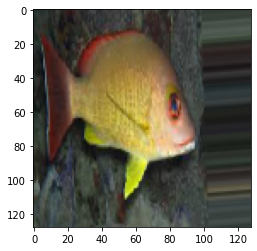

In [58]:
plt.imshow(X_train[3962])

In [59]:
y_train[3962]

9

In [61]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))

In [63]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs = -1, multi_class = 'multinomial', solver = 'lbfgs')

logreg.fit(X_train_reshaped, y_train)

CPU times: user 1.35 s, sys: 2.8 s, total: 4.15 s
Wall time: 13min 47s


LogisticRegression(multi_class='multinomial', n_jobs=-1)

In [65]:
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3]))

In [66]:
logreg.score(X_test_reshaped, y_test)

0.24489795918367346

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, logreg.predict(X_test_reshaped)))

              precision    recall  f1-score   support

           0       0.25      0.32      0.28        38
           1       0.37      0.24      0.29        42
           2       0.23      0.22      0.22        37
           3       0.17      0.06      0.09        34
           4       0.33      0.53      0.40        38
           5       0.23      0.31      0.26        36
           6       0.11      0.13      0.12        30
           7       0.38      0.19      0.25        42
           8       0.11      0.09      0.10        45
           9       0.23      0.25      0.24        28
          10       0.26      0.45      0.33        22

    accuracy                           0.24       392
   macro avg       0.24      0.25      0.24       392
weighted avg       0.25      0.24      0.23       392

